# Imports

In [34]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=0)
RANDOM_STATE = 1

# Read data
- read csv files
- shuffle
- separate X, y


In [2]:
def read_csvs(csv_files, verbose=True):
    '''Read a list of csv files into a single ndarray'''
    m = np.array([])
    for csv in csv_files:
        if verbose:
            print('loading:', csv)
        a = np.genfromtxt(csv, delimiter=',')
        if (0 == m.shape[0]):
            m = a
        else:
            m = np.append(m, a, axis=0)
    return m

# read csv files
csv_files = [os.path.join('data', f) for f in os.listdir('data')]

# read first file only: df = read_csvs([csv_files[0]], verbose=False)
M = read_csvs(csv_files, verbose=True)

# suffle
np.random.shuffle(M)

# separate X from y
y = M[:, 0]
X = M[:, 1:].astype(int)

print('X.shape:', X.shape)
print('y.shape:', y.shape)


loading: data/yulesimon_alpha=2.71_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.35_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.64_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.36_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.16_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.03_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.84_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.09_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.69_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.96_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.80_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.49_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.25_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.57_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_alpha=2.66_loc=0_rows=100_cols=10000.csv
loading: data/yulesimon_a

# Preprocess data

In [3]:
# convert rows of X to a histogram H
nbins = np.max(X)
H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

# log scale H rows
logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)
# log number of bins
log_bins = np.log10(np.arange(nbins))

## Plot logH

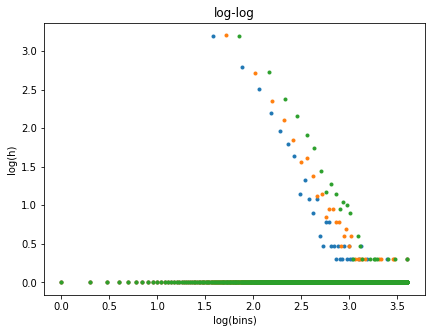

In [4]:
# plot
plt.figure(figsize=(15, 5))
ax2 = plt.subplot(1, 2, 2)
plt.gca().set(title='log-log', xlabel='log(bins)', ylabel='log(h)')
plt.scatter(log_bins, logH[0], marker='.')
plt.scatter(log_bins, logH[1], marker='.')
plt.scatter(log_bins, logH[3], marker='.')

print()

## Drop zeros

In [5]:
# def drop_zeros(t):
#     idx = np.argwhere(t > 0)
#     rows,cols = np.max(idx, axis=0)
#     res = np.zeros((rows+1,cols+1))

#     ks = np.zeros(idx.shape[0], dtype=int)
#     for i, j in idx:
#         res[i, ks[i]] = t[i,j]
#         ks[i] += 1
#     return res

# def drop_zero_columns(t):
#     idx = np.where(t.any(axis=0))[0]
#     return t[np.ix_(np.arange(t.shape[0]), idx)]

# if False:
#     logH = drop_zero_columns(drop_zeros(logH))
#     log_bins = np.log10(np.arange(logH.shape[1]))


## Interpolate zeros

In [6]:
# from scipy.interpolate import interp1d

# def get_row_interp1d(a):
#     x = np.nonzero(a)[0]
#     y = a[x]
#     return interp1d(x, y, 'linear')

# def get_interp1d(a):
#     return np.apply_along_axis(lambda a: get_row_interp1d(a), 1, a)

# def non_zeros_range(a):
#     len_a = a.shape[1]
#     min_index = np.apply_along_axis(lambda a: np.argmax(a[1:]>0)+1, 1, a)
#     max_index = np.apply_along_axis(lambda a: len_a - 1 - np.argmax(a[1:]>0)-1, 1, np.flip(a, axis=1))
#     return min_index, max_index

# def get_zero_indices(a):
#     min_index, max_index = non_zeros_range(a)
#     min_max_zero_indices = [[j for j in range(len(a[i])) 
#         if a[i,j] == 0 
#             and j>min_index[i]
#             and j <= max_index[i]] for i in range(len(a))]
#     return min_index, max_index, min_max_zero_indices

# def interpolate(a, zero_indices, interp):
#     for i in range(len(zero_indices)):
#         res = interp[i](zero_indices[i])
#         # print('zero_indices[i]:', zero_indices[i])
#         for j in range(len(res)):
#             # print(i,zero_indices[i][j],res[j])
#             a[i, zero_indices[i][j]] = res[j]

# interp = get_interp1d(logH)
# min_index, max_index, zero_indices = get_zero_indices(logH)
# interpolate(logH, zero_indices, interp)

In [7]:
# plt.figure(figsize=(15, 5))
# ax2 = plt.subplot(1, 2, 2)
# plt.gca().set(title='log-log (interp-middle-zeros)', xlabel='log(bins)', ylabel='log(h)')
# plt.scatter(log_bins, logH[0], marker='.', s=3)
# plt.scatter(log_bins, logH[1], marker='.', s=3)
# plt.scatter(log_bins, logH[2], marker='.', s=3)
# print()

In [8]:
# for row in range(logH.shape[0]):
#     logH[row][1:min_index[row]] = logH[row][min_index[row]]

In [9]:
# plt.figure(figsize=(15, 5))
# ax2 = plt.subplot(1, 2, 2)
# plt.gca().set(title='log-log (interp-left-zeros)', xlabel='log(bins)', ylabel='log(h)')
# plt.scatter(log_bins, logH[0], marker='.', s=3)
# plt.scatter(log_bins, logH[1], marker='.', s=3)
# plt.scatter(log_bins, logH[2], marker='.', s=3)
# print()

In [10]:
# zzz = np.apply_along_axis(lambda a: np.cumsum(a[::-1])[::-1], 1, logH)

# from sklearn import preprocessing
# zzz = preprocessing.scale(zzz, axis=1)

# plt.figure(figsize=(15, 5))
# ax2 = plt.subplot(1, 2, 2)
# plt.gca().set(title='log-log (interp-left-zeros)', xlabel='log(bins)', ylabel='log(h)')
# for i in range(3):
#     plt.scatter(log_bins, zzz[i], marker='.', s=3)
# print()

## split train/validation/test

In [11]:
# train/test
X_train, X_test, y_train, y_test = train_test_split(logH, y, test_size=0.2, random_state=RANDOM_STATE)
# X_train, X_test, y_train, y_test = train_test_split(logH[:,1:-1], y, test_size=0.2, random_state=RANDOM_STATE)
# X_train, X_test, y_train, y_test = train_test_split(zzz, y, test_size=0.2, random_state=RANDOM_STATE)

# train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('X_test.shape: {}'.format(X_test.shape))


X_train.shape: (6000, 4069)
X_val.shape: (2000, 4069)
X_test.shape: (2000, 4069)


## Create Model

In [53]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    
    # ============
    # input-layer
    # ============
    model.add(Dense(units=layers[0]
                      , input_dim=n_features
                      , kernel_initializer=init
                      , activation=activation
                      , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                      , activity_regularizer=l2(a_reg_lr) if a_reg else None
                    ))
    
    
    if batch_normalization:
        model.add(BatchNormalization())

    if dropout > 0:
        model.add(Dropout(dropout))

    # ==============
    # hidden-layers
    # ==============
    for units in layers[1:]:
        model.add(Dense(units=units
                        , kernel_initializer=init
                        , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                        , activity_regularizer=l2(a_reg_lr) if a_reg else None
                        ))

    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation(activation))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    # =============
    # output-layer
    # =============
    model.add(Dense(units=1
                    , activation='linear'
                    , kernel_initializer=init
                    , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                    , activity_regularizer=l2(a_reg_lr) if a_reg else None
                    ))
    
    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

    return model

## Training

In [58]:
# BATCH_SIZE = 32
# BATCH_SIZE = 8
BATCH_SIZE = 4
MODEL_PREFIX = 'yulesimon'

def train(X_train, y_train):
    model = create_model(X_train.shape[1], 
                        #  layers=[32],
                        #  layers=[32,32], 
                         layers=[256,128], 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=False, 
                         dropout=0.0, 
                        #  optimizer=Adam(lr=1e-3), 
                         optimizer=SGD(lr=1e-3, momentum=0.9, decay=0.01), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 20
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=1)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/{}_{}'.format(MODEL_PREFIX, date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=20)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=3000, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, callbacks=[es, reduce_lr, cp], 
                        verbose=1)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    print('model path:', model_path)
    model = keras.models.load_model(model_path)
    return model, history.history

# ------------------------------------------------------
# RUN: either train from scratch OR load existing model
# ------------------------------------------------------

LOAD_BEST = False
if LOAD_BEST:
    model_path = 'models/yulesimon_06-09-2020_23-21-37.h5'
    history_path = 'models/yulesimon_06-09-2020_23-21-37.history'
else:
    model_path = None
    history_path = None

model, history = None, None

if None == model_path:
    model, history = train(X_train, y_train)
else: # load existing model
    model = keras.models.load_model(model_path)
    if history_path:
        with open(history_path, 'rb') as f:
            history = pickle.load(f)

====================] - ETA: 0s - loss: 0.0055 - mse: 0.0042
Epoch 00068: val_loss did not improve from 0.01203
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0055 - mse: 0.0042 - val_loss: 0.0123 - val_mse: 0.0110
Epoch 69/3000
1499/1500 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0042
Epoch 00069: val_loss did not improve from 0.01203
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0055 - mse: 0.0042 - val_loss: 0.0123 - val_mse: 0.0109
Epoch 70/3000
1497/1500 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0042
Epoch 00070: val_loss improved from 0.01203 to 0.01201, saving model to models/yulesimon_06-09-2020_23-21-37.h5
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0055 - mse: 0.0042 - val_loss: 0.0120 - val_mse: 0.0107
Epoch 71/3000
1495/1500 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0041
Epoch 00071: val_loss did not improve from 0.01201
1500/1500 [

## Plot learning curves

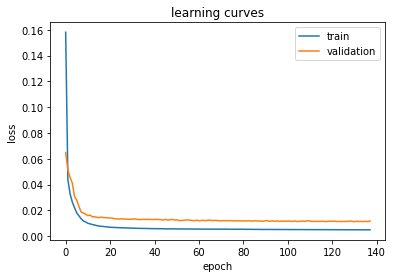

In [59]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

if True and history:
    plot_learning_curves(history)

## Predict & test accuracy

In [60]:
y_pred = model.predict(X_test).flatten()
abs_residuals = np.abs(y_test - y_pred)

print()
num_samples = abs_residuals.shape[0]
for max_abs_error in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    acc = np.sum((abs_residuals <= max_abs_error).astype(int), axis=0) / num_samples
    print('acc (max_abs_error = {}):'.format(max_abs_error), acc)

print()
print('average abs_residuals:\t', np.average(abs_residuals))

squared_error = np.square(y_test - y_pred)
mse = (squared_error).mean(axis=0)
print('mean squared error:\t', mse)

df_errors = pd.DataFrame({
    'y_test': y_test, 
    'y_pred': y_pred, 
    'abs_residuals': abs_residuals, 
    'squared_error': squared_error
})

df_errors = df_errors[['y_test', 'y_pred', 'abs_residuals', 'squared_error']]
df_errors_sorted = df_errors.sort_values(by='squared_error', ascending=False)
df_errors_sorted.head()


acc (max_abs_error = 0.01): 0.0925
acc (max_abs_error = 0.02): 0.178
acc (max_abs_error = 0.03): 0.267
acc (max_abs_error = 0.04): 0.3605
acc (max_abs_error = 0.05): 0.428
acc (max_abs_error = 0.06): 0.4945
acc (max_abs_error = 0.07): 0.555
acc (max_abs_error = 0.08): 0.609
acc (max_abs_error = 0.09): 0.655
acc (max_abs_error = 0.1): 0.702

average abs_residuals:	 0.07525431073188783
mean squared error:	 0.009264532606024495


,y_test,y_pred,abs_residuals,squared_error
95,2.17,2.540037,0.370037,0.136927
287,2.45,2.816252,0.366252,0.134140
1194,2.94,2.579748,0.360252,0.129781
1009,2.54,2.871762,0.331762,0.110066
869,2.97,2.643584,0.326416,0.106548


# Plot y_test vs y_pred

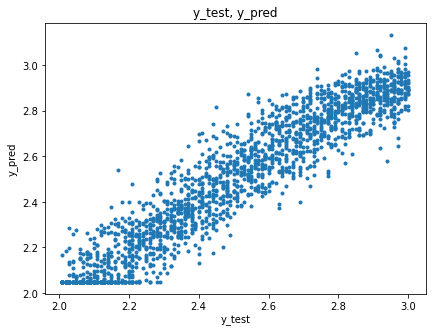

In [61]:
plt.figure(figsize=(15, 5))
ax2 = plt.subplot(1, 2, 2)
plt.gca().set(title='y_test, y_pred', xlabel='y_test', ylabel='y_pred')
plt.scatter(y_test, y_pred, marker='.')
print()